# Maximizing throughput across jobs

In [1]:
import csv
cluster_num_gpus=4

def get_baseline_perf(job, exec_plan, num_gpus):
    baseline_perf = 0
    job_trace = "../../simulator/traces/" + job + "/placements.csv"
    with open(job_trace, "r", encoding="utf-8-sig") as data:
        reader_config = csv.DictReader(data)
        data_rows = list(reader_config)
    for data_row in data_rows:
        if (
            data_row["placement"] == str(num_gpus)
            and data_row["exec_plan"] == exec_plan
        ):
            baseline_perf = data_row["iter_time"]
    return float(baseline_perf)

jobs = ["roberta","t5_3B"]

scheduler_norm_tpt = {}
for job in jobs:
    scheduler_norm_tpt.setdefault(job, {})

scheduler_norm_tpt["roberta"]["baseline"] = get_baseline_perf("roberta", "ga", cluster_num_gpus)
scheduler_norm_tpt["t5_3B"]["baseline"] = get_baseline_perf("t5_3B", "tp+ga", cluster_num_gpus)

## Simple Scheduler Allocation

In [2]:
from simple_scheduler import SimpleScheduler

simple_scheduler = SimpleScheduler(cluster_num_gpus)
simple_scheduler.submit("roberta")
simple_scheduler.submit("t5_3B")
simple_scheduler.allocate()
job_performance = simple_scheduler.simulate()
print('Simple Scheduler: allocates 2 GPUs to each job.')
for job in job_performance:
    print(f'{job} takes {job_performance[job][0]} seconds under {job_performance[job][1]}.')
    scheduler_norm_tpt[job]["Simple"]=round(scheduler_norm_tpt[job]["baseline"]/job_performance[job][0],2)
    print(f'The normalized throughput of {job} is {scheduler_norm_tpt[job]["Simple"]}.')

Simple Scheduler: allocates 2 GPUs to each job.
roberta takes 0.697693418 seconds under zero-dp.
The normalized throughput of roberta is 0.53.
t5_3B takes 3.2757 seconds under zero-offload.
The normalized throughput of t5_3B is 0.25.


## Morphling Scheduler Reconfiguration

In [3]:
from Morphling_scheuler import MorphlingScheduler
morphling_scheduler = MorphlingScheduler(cluster_num_gpus)
morphling_scheduler.submit("roberta")
morphling_scheduler.submit("t5_3B")
print('Morphling Scheduler: maximizes throughput considering jobs’ resource sensitivity.')
allocation = morphling_scheduler.allocate()
print(f'Reconfiguration result:')
for job in jobs:
    print(f'  allocates {allocation[job][0]} GPUs to {job}, and reconfigures it to use {allocation[job][1]}.')

job_performance = morphling_scheduler.simulate()
for job in job_performance:
    print(f'{job} takes {job_performance[job][0]} seconds under {job_performance[job][1]}.')
    scheduler_norm_tpt[job]["Morphling"]=round(scheduler_norm_tpt[job]["baseline"]/job_performance[job][0],2)
    print(f'The normalized throughput of {job} is {scheduler_norm_tpt[job]["Morphling"]}.')

/Users/zhizhi/opt/anaconda3/lib/python3.9/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'validate_all' has been renamed to 'validate_default'
  warnings.warn(message, UserWarning)
/Users/zhizhi/opt/anaconda3/lib/python3.9/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_persistence_threshold" in DeepSpeedZeroConfig has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/zhizhi/opt/anaconda3/lib/python3.9/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'validate_all' has been renamed to 'validate_default'
  warnings.warn(message, UserWarning)
NOTE: Redirects are currently not supported in Windows or MacOs.


Morphling Scheduler: maximizes throughput considering jobs’ resource sensitivity.
Reconfiguration result:
  allocates 1 GPUs to roberta, and reconfigures it to use zero-dp+ga.
  allocates 3 GPUs to t5_3B, and reconfigures it to use tp+ga.
roberta takes 0.68361435 seconds under zero-dp.
The normalized throughput of roberta is 0.55.
t5_3B takes 0.9301 seconds under tp+ga.
The normalized throughput of t5_3B is 0.89.


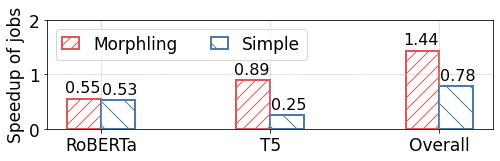

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 17,'lines.linewidth': 4.3})

plt.figure(figsize=(8,2))

# Bar chart configuration
size = 3
x = np.arange(size)
total_width, n = 0.4, 2
width = total_width / n
x = x - (total_width - width) / 2
colors = ["#E15759", "#4E79A7"]
hatchs = ["//", "\\"]

i=0
text_x=-0.11
for scheduler in ["Morphling","Simple"]:
    norm_tpt = []
    for job in scheduler_norm_tpt:
        norm_tpt.append(scheduler_norm_tpt[job][scheduler])
    norm_tpt.append(sum(norm_tpt))
    plt.bar(x, norm_tpt, edgecolor=colors[i],linewidth=2, width=width, label=scheduler,hatch=hatchs[i],fill=False)
    for tpt in norm_tpt:
        plt.text(text_x,tpt+0.2,tpt,ha='center', va='center',fontsize=16)
        text_x+=1
    x+=width
    i+=1
    text_x=0.11
    

plt.ylabel("Speedup of jobs")
plt.legend(loc="upper left",ncol=2,handlelength=1)
plt.xticks([0,1,2],["RoBERTa","T5","Overall"])
plt.ylim([0,2])
plt.grid(linestyle = 'dashed', linewidth = 0.5)
